# 1. Modèle personnel

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from time import time

%cd ..
import src.mytools as mt
%cd notebooks

2024-07-17 18:23:40.148051: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 18:23:41.321365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/chakir/Bureau/PROJETS/Projet6
/home/chakir/Bureau/PROJETS/Projet6/notebooks


In [6]:
# Chemin vers les dossiers 'train', 'validation' et 'test'
train_dir = '../data/train'
val_dir = '../data/validation'
test_dir = '../data/test'

class_names = os.listdir(val_dir)

In [7]:
# Fixation des sources des générateurs aléatoires pour assurer la reproductibilité des résultats.
seed_value = 42
set_random_seed(seed_value)

In [8]:
mlflow.set_tracking_uri("http://ec2-52-209-5-80.eu-west-1.compute.amazonaws.com:5000")
mlflow.set_experiment('projet6_modele-personnel')

<Experiment: artifact_location='s3://mlflow-cfikri/714684247742515781', creation_time=1721031642342, experiment_id='714684247742515781', last_update_time=1721031642342, lifecycle_stage='active', name='projet6_modele-personnel', tags={}>

In [9]:
def compile_and_train(model,
                      train_data,
                      val_data,
                      loss='categorical_crossentropy',
                      optimizer=Adam,
                      learning_rate=0.001,
                      metrics=['accuracy', 'precision', 'recall', 'auc'],
                      epochs=20,
                      stopping=10,
                      lr_patience=5,
                      factor=0.5,
                      verbose=1
                     ):
    
    # Compilation du modèle
    model.compile(loss=loss,
                  optimizer=optimizer(learning_rate=learning_rate),
                  metrics=metrics
                 )
    
    # Construction des callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=stopping, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=lr_patience, min_lr=0.0001)
    
    debut = time()
    
    # Entraînement du modèle
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=verbose
                       )
    fin = time()
    
    duree = fin - debut
    
    return history, round(duree/60)

In [10]:
def graphique_auc_perte(history, model_name):
    
    # Récupérer les données d'entraînement
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    
    # Récupérer les données de perte
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    fig, axe = plt.subplots(1,2, figsize = (10,5))
    axe = axe.flatten()

    # Premier subplot : Courbes des AUCs
    axe[0].plot(epochs, auc, 'b', label='Training AUC')
    axe[0].plot(epochs, val_auc, 'r', label='Validation AUC')
    axe[0].set_title('Training and validation AUC')
    axe[0].set_xlabel('Epochs')
    axe[0].set_ylabel('AUCs')
    axe[0].legend()
    axe[0].grid(True)

    # Deuxième subplot : Loss et Validation loss
    axe[1].plot(epochs, loss, 'b', label='Training loss')
    axe[1].plot(epochs, val_loss, 'r', label='Validation loss')
    axe[1].set_title('Training and validation loss')
    axe[1].set_xlabel('Epochs')
    axe[1].set_ylabel('Loss')
    axe[1].legend()
    axe[1].grid(True)

    plt.tight_layout()
    plt.savefig(f'../outputs/courbes_performances_{model_name}.png')
    plt.show()

In [11]:
def matrice_confusion(model, model_name, val_data, class_names=None):
    """
    Affiche la matrice de confusion pour un modèle donné et des données de validation.

    Parameters:
    model : tensorflow.keras.Model
        Le modèle entraîné.
    val_data : tensorflow.keras.preprocessing.image.DirectoryIterator
        Les données de validation.
    class_names : list, optional
        Les noms des classes. Par défaut, None.
    """
    
    # Prédiction des étiquettes sur les données de validation
    val_preds = model.predict(val_data)
    val_preds_classes = np.argmax(val_preds, axis=1)
    
    # Récupération des vraies étiquettes
    val_true_classes = val_data.classes

    # Calcul de la matrice de confusion
    cm = confusion_matrix(val_true_classes, val_preds_classes)
    
    # Utilisation de ConfusionMatrixDisplay pour afficher la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title('Matrice de confusion')
    plt.savefig(f'../outputs/matrice_confusion_{model_name}.png')
    plt.show()

## 1.2. Entraînement de CNN sans data augmentation

#### 1.2.1 CNN À UNE COUCHE CONVOLUTIONNELLE

Commençons par construire les générateurs d'images d'entraînement et de validation :

In [16]:
# Définition des générateurs de données
generator = ImageDataGenerator(rescale=1./255)

train_generator = generator.flow_from_directory(train_dir,
                                                target_size=(256, 256),
                                                class_mode='categorical',
                                                seed=seed_value
                                               )

val_generator = generator.flow_from_directory(val_dir,
                                               target_size=(256, 256),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed_value
                                              )

Found 288 images belonging to 3 classes.
Found 72 images belonging to 3 classes.


On commence par un CNN simple avec une couche convolutionnelle et une couche fully-connected :

In [19]:
# Construction du modèle CNN
model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(3, activation='softmax')  # 3 classes
                   ])

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


On entraîne le modèle sur 20 époques :

In [21]:
history, temps_execution = compile_and_train(model, train_generator, val_generator)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/20


/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3938 - auc: 0.5298 - loss: 19.8030 - precision: 0.3065 - recall: 0.2468 - val_accuracy: 0.4028 - val_auc: 0.5320 - val_loss: 5.8114 - val_precision: 0.4028 - val_recall: 0.4028 - learning_rate: 0.0010
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5207 - auc: 0.6600 - loss: 3.3499 - precision: 0.5275 - recall: 0.5101 - val_accuracy: 0.3472 - val_auc: 0.5499 - val_loss: 1.7442 - val_precision: 0.3731 - val_recall: 0.3472 - learning_rate: 0.0010
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6036 - auc: 0.8057 - loss: 0.8563 - precision: 0.6659 - recall: 0.5340 - val_accuracy: 0.3611 - val_auc: 0.5754 - val_loss: 1.2500 - val_precision: 0.3774 - val_recall: 0.2778 - learning_rate: 0.0010
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8487 - auc: 0.9634 - loss: 0.4541 - precision: 0.8990 - recall: 0.7316 - val_accuracy: 0.3750 - val_auc: 0.6180 - val_loss: 1.1569 - val_precision: 0.4773 - val_r

On affiche l'évolution de l'AUC-ROC et de l'entropie croisée au cours des époques, sur les ensembles d'entraînement et de validation :

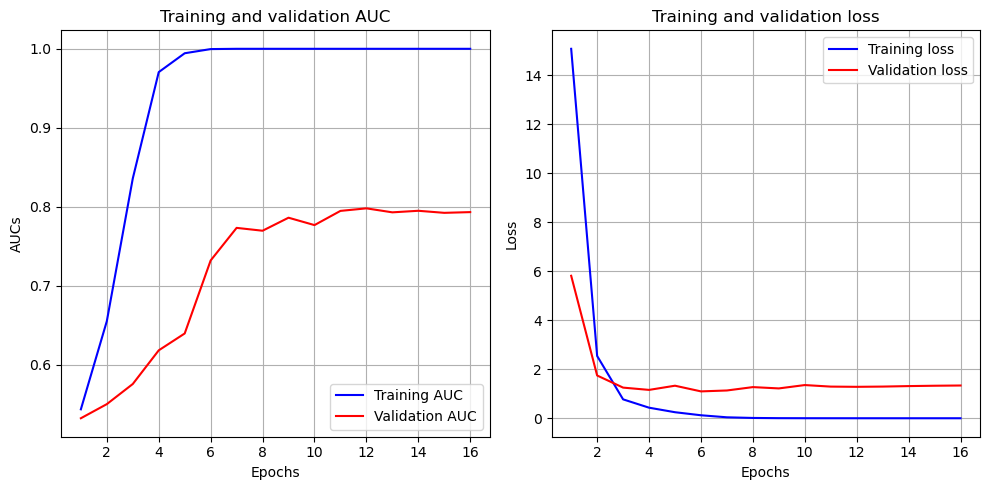

In [22]:
graphique_auc_perte(history, 'model1')

On constate que le modèle est déjà en surapprentissage, il est donc inutile de le complexifier en ajoutant des couches supplémentaires. Nous allons régulariser le modèle en ajoutant, après chaque couche convolutionnelle ou dense, un dropout. Nous allons tester des valeurs de dropout allant de 0.2 à 0.5 avec un pas de 0.1.

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


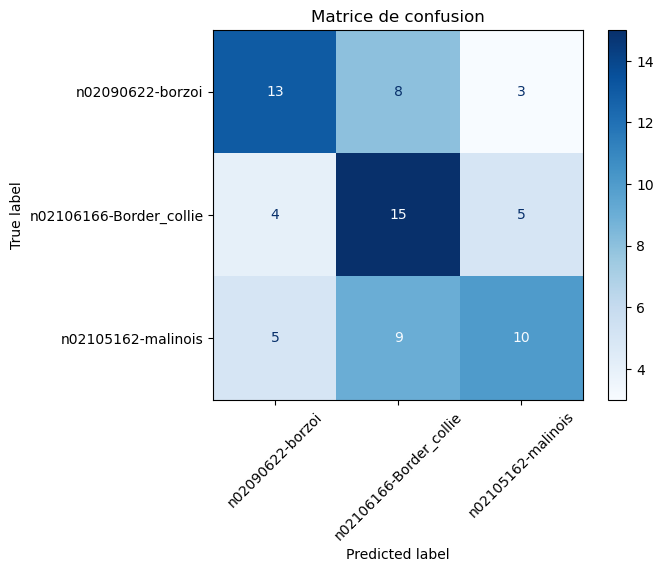

In [23]:
matrice_confusion(model, 'model1', val_generator, class_names)

On enregistre ce run dans MLflow :

In [24]:
params = {'algorithme' : 'CNN_personnel', 'nbr_couches' : 2, 
          'nbr_couches_convolutionnelles' : 1, 
          'optimizer' : 'Adam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 20}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model1.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model1.png'}

mt.log_mlflow_run('CNN_1_couche_sans_data_augmentation', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-1-couche')

2024/07/16 12:43:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### 1.2.2 CNN À UNE COUCHE CONVOLUTIONNELLE AVEC RÉGULARISATION

La fonction `create_model` suivante prend en argument une valeur de **dropout** et renvoi le modèle CNN correspondant, comme décrit précédemment :

In [18]:
# Construction du modèle CNN
def create_model(dropout):
    model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                        MaxPooling2D((2, 2)),
                        Dropout(dropout),
                        Flatten(),
                        Dense(128, activation='relu'),
                        Dropout(dropout),
                        Dense(3, activation='softmax')  # 3 classes
                       ])
    return model

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


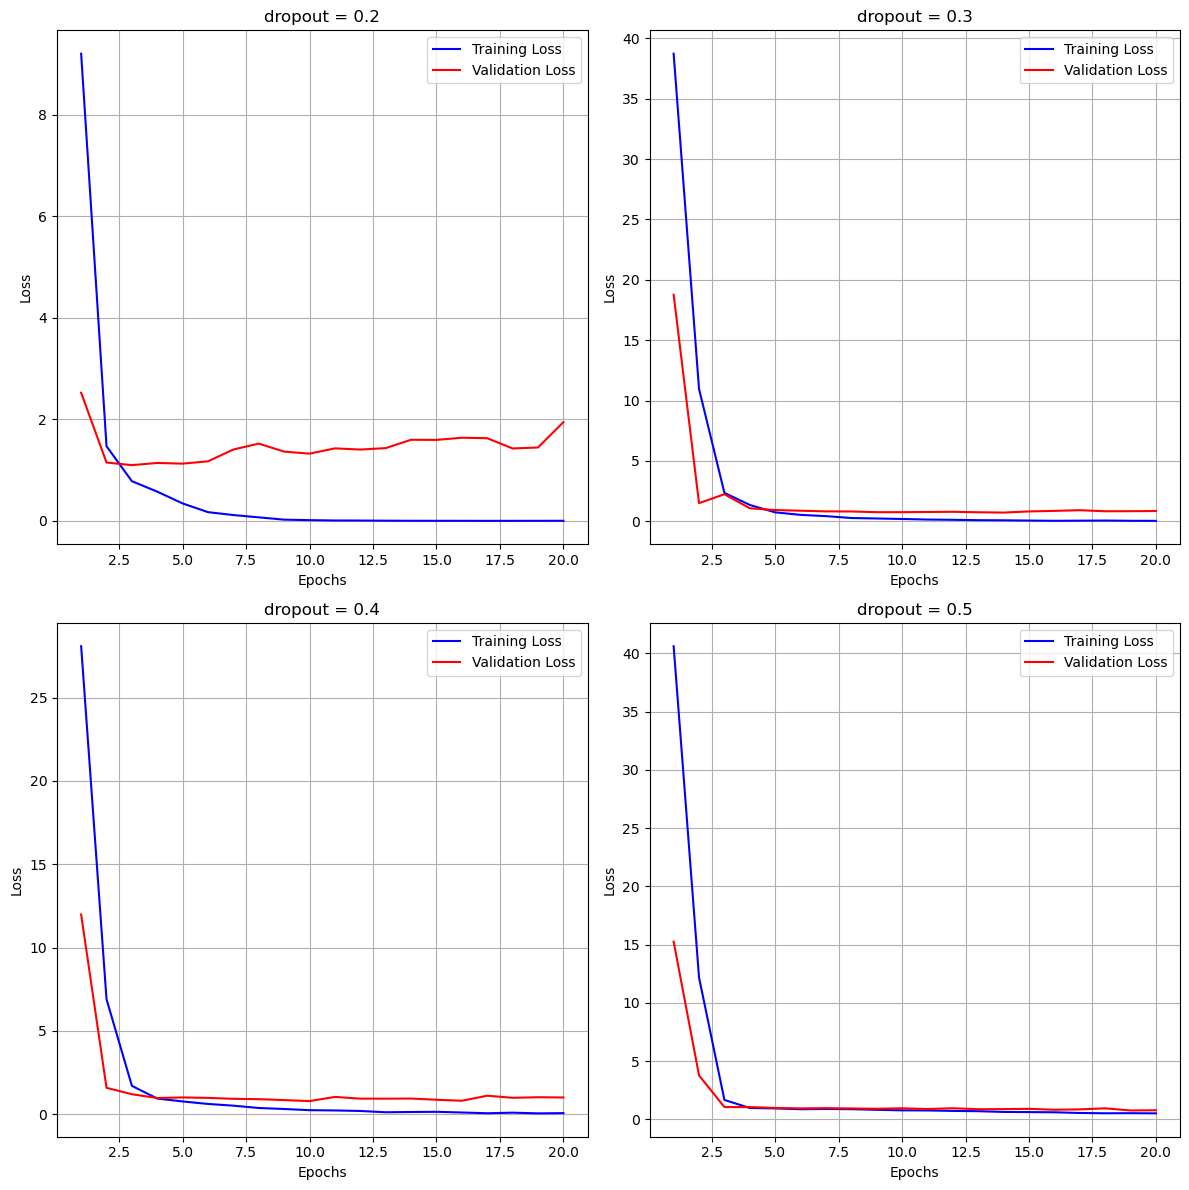

Durée d'exécution : 19 min


In [23]:
# Valeurs des paramètres à tester
dropouts = [0.2, 0.3, 0.4, 0.5]

epochs = range(1,21)

fig, axe = plt.subplots(2,2, figsize = (12,12))
axe = axe.flatten()

debut = time()

for i, dropout in enumerate(dropouts):
        
    # Compilation du modèle
    model = create_model(dropout)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['auc'])
        
    # Entraînement du modèle
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=20,
                        verbose=0)
        
    # Récupération des pertes
    loss = history.history['loss']
    val_loss = history.history['val_loss']
        
    # Graphiques : Pertes d'entraînement et de validation
    axe[i].plot(epochs, loss, 'b', label='Training Loss')
    axe[i].plot(epochs, val_loss, 'r', label='Validation Loss')
    axe[i].set_xlabel('Epochs')
    axe[i].set_ylabel('Loss')
    axe[i].set_title(f'dropout = {dropout}')
    axe[i].legend()
    axe[i].grid(True)

plt.tight_layout()
plt.savefig(f'../outputs/courbes_performances_selon_dropout.png')
plt.show()

fin = time()
duree = fin - debut
print(f"Durée d'exécution : {round(duree/60)} min")

On peut voir une diminution conséquente du surapprentissage à partir de 30% de dropout. Il semble que le dropout optimal est de 50%. Nous allons entraîné le modèle avec 50% de dropout sur 50 époques :

In [32]:
# Construction du modèle CNN
model = create_model(0.5)

In [34]:
history, temps_execution = compile_and_train(model, train_generator, val_generator, stopping=20, lr_patience=10, epochs=50)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3428 - auc: 0.4908 - loss: 30.3348 - precision: 0.3047 - recall: 0.2601 - val_accuracy: 0.3333 - val_auc: 0.5104 - val_loss: 17.2688 - val_precision: 0.3333 - val_recall: 0.3333 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3497 - auc: 0.4999 - loss: 13.0234 - precision: 0.3487 - recall: 0.3457 - val_accuracy: 0.3333 - val_auc: 0.5257 - val_loss: 2.0274 - val_precision: 0.3380 - val_recall: 0.3333 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3837 - auc: 0.5835 - loss: 1.6949 - precision: 0.4252 - recall: 0.3237 - val_accuracy: 0.4444 - val_auc: 0.5930 - val_loss: 1.0750 - val_precision: 0.5000 - val_recall: 0.0278 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4042 - auc: 0.6452 - loss: 1.0325 - precision: 0.9088 - recall: 0.0885 - val_accuracy: 0.4722 - val_auc: 0.6143 - val_loss: 1.0774 - val_precision: 0

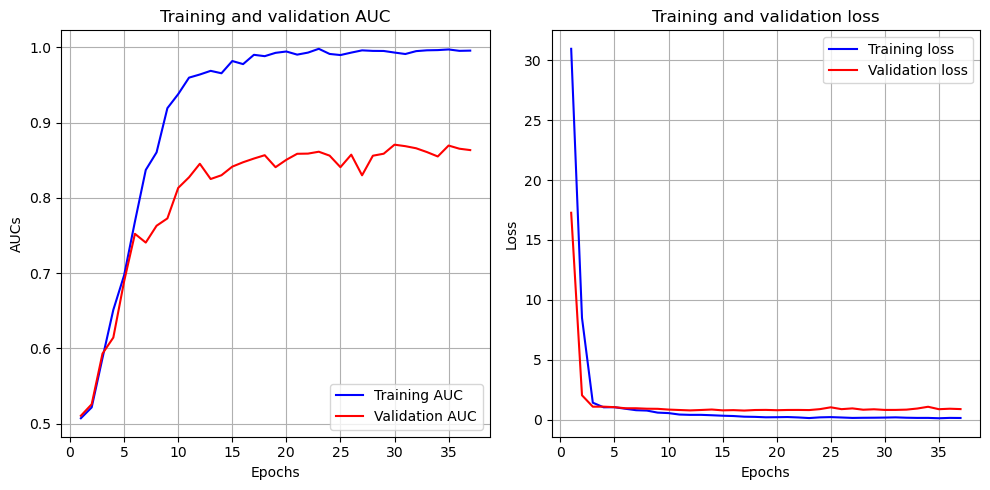

In [36]:
graphique_auc_perte(history, 'model2')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


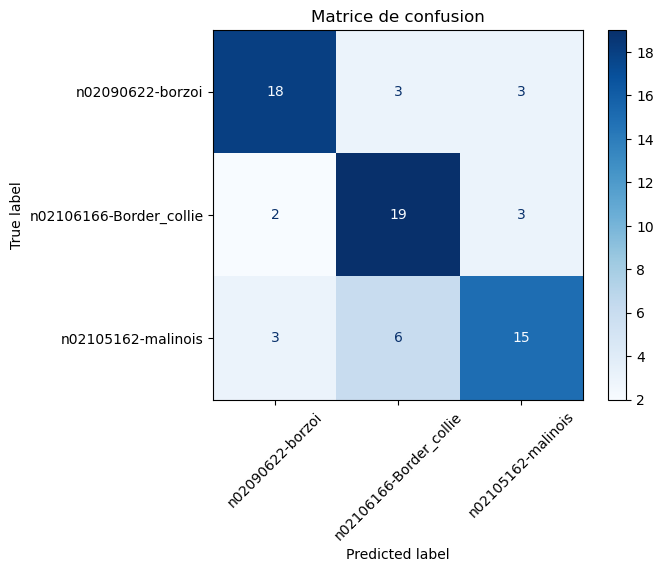

In [38]:
matrice_confusion(model, 'model2', val_generator, class_names)

On observe une nette diminution de l'overfit et une amélioration des performances : On passe d'un AUC-ROC de 0.8 à 0.85 sur les données de validation. Cependant, l'overfit reste assez important.

On enregistre dans MLflow :

In [40]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 2, 
          'nbr_couches_convolutionnelles' : 1, 
          'optimizer' : 'Adam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 50,
          'dropouts_testes' : [0.2, 0.3, 0.4, 0.5],
          'dropout_optimal' : 0.4}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Performances selon dropouts" : '../outputs/courbes_performances_selon_dropout.png',
             "Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model2.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model2.png'}

mt.log_mlflow_run('CNN_1_couche_sans_data_augmentation_avec_dropout', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-1-couche')

2024/07/16 14:44:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## 1.3. Entraînement de CNN avec data augmentation

#### 1.3.1 CNN à une couche convolutionnelle



In [20]:
# Définition des générateurs de données

t_generator = ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.4,
                                 horizontal_flip=True,
                                 fill_mode='nearest'
                                )

generator = ImageDataGenerator(rescale=1./255)

train_generator = t_generator.flow_from_directory(train_dir,
                                                  target_size=(256, 256),
                                                  class_mode='categorical',
                                                  seed=seed_value
                                                 )

val_generator = generator.flow_from_directory(val_dir,
                                              target_size=(256, 256),
                                              class_mode='categorical',
                                              shuffle=False,
                                              seed=seed_value
                                             )

Found 288 images belonging to 3 classes.
Found 72 images belonging to 3 classes.


In [20]:
# Construction du modèle CNN
model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(3, activation='softmax')  # 3 classes
                   ])

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
history, temps_execution = compile_and_train(model, train_generator, val_generator)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/20


/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3940 - auc: 0.5381 - loss: 16.5631 - precision: 0.3193 - recall: 0.2562 - val_accuracy: 0.3333 - val_auc: 0.5524 - val_loss: 4.0022 - val_precision: 0.3333 - val_recall: 0.3333 - learning_rate: 0.0010
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3933 - auc: 0.5627 - loss: 2.1143 - precision: 0.3901 - recall: 0.3798 - val_accuracy: 0.3750 - val_auc: 0.4888 - val_loss: 1.4278 - val_precision: 0.3220 - val_recall: 0.2639 - learning_rate: 0.0010
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4166 - auc: 0.6217 - loss: 1.0644 - precision: 0.5031 - recall: 0.1728 - val_accuracy: 0.3194 - val_auc: 0.5065 - val_loss: 1.1445 - val_precision: 0.4545 - val_recall: 0.1389 - learning_rate: 0.0010
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3804 - auc: 0.5794 - loss: 1.0792 - precision: 0.5774 - recall: 0.0457 - val_accuracy: 0.3472 - val_auc: 0.5088 - val_loss: 1.1038 - val_precision: 0.6250 - val_r

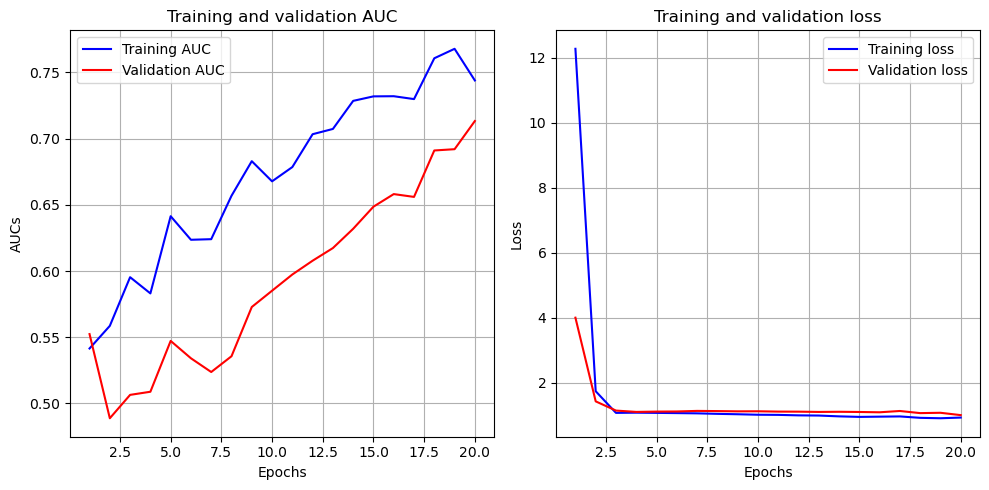

In [24]:
graphique_auc_perte(history, 'model3')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step


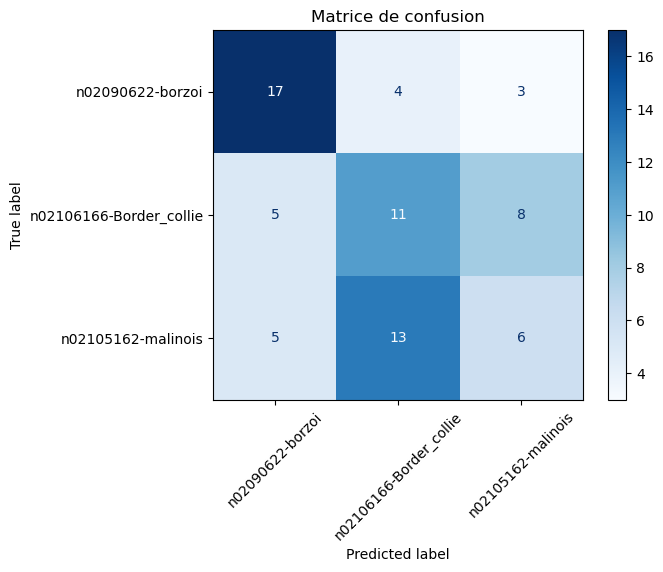

In [26]:
matrice_confusion(model, 'model3', val_generator, class_names)

In [28]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 2, 
          'nbr_couches_convolutionnelles' : 1, 
          'optimizer' : 'Adam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 20}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model3.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model3.png'}

mt.log_mlflow_run('CNN_1_couche_avec_data_augmentation', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-1-couche')

2024/07/16 21:48:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [30]:
# Construction du modèle CNN
model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(3, activation='softmax')  # 3 classes
                   ])

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
history, temps_execution = compile_and_train(model, train_generator, val_generator)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2786 - auc: 0.4680 - loss: 16.8415 - precision: 0.2598 - recall: 0.2051 - val_accuracy: 0.5000 - val_auc: 0.6041 - val_loss: 1.2837 - val_precision: 0.6071 - val_recall: 0.2361 - learning_rate: 0.0010
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3960 - auc: 0.5548 - loss: 1.1416 - precision: 0.4874 - recall: 0.1257 - val_accuracy: 0.3333 - val_auc: 0.4650 - val_loss: 1.1282 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3165 - auc: 0.5324 - loss: 1.0919 - precision: 0.4033 - recall: 0.0137 - val_accuracy: 0.4167 - val_auc: 0.5682 - val_loss: 1.0867 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3828 - auc: 0.5839 - loss: 1.0768 - precision: 0.5000 - recall: 0.0054 - val_accuracy: 0.4861 - val_auc: 0.6781 - val_loss: 1.0368 - va

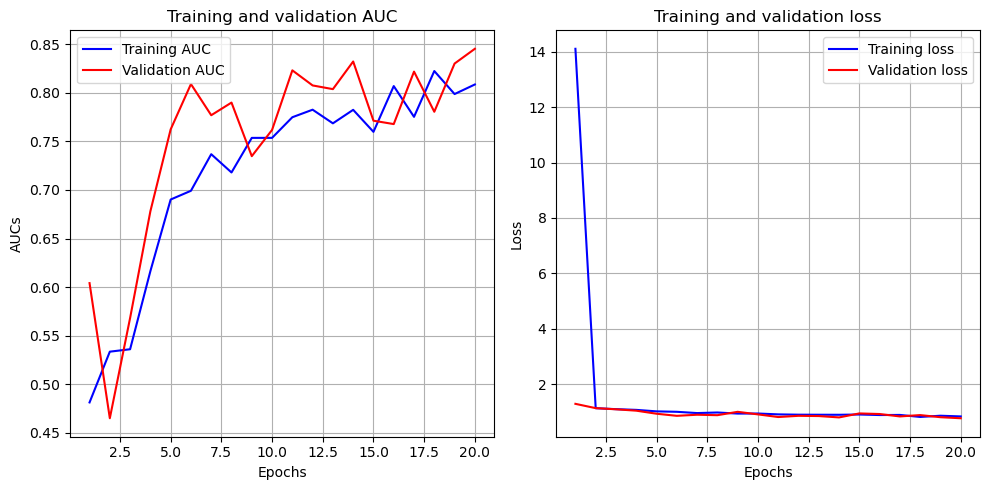

In [34]:
graphique_auc_perte(history, 'model4')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step


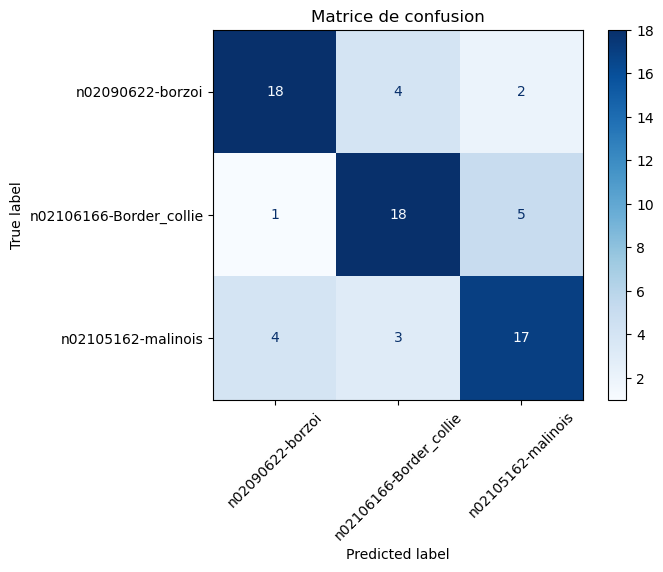

In [36]:
matrice_confusion(model, 'model4', val_generator, class_names)

In [38]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 3, 
          'nbr_couches_convolutionnelles' : 2, 
          'optimizer' : 'Adam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 20}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model4.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model4.png'}

mt.log_mlflow_run('CNN_2_couches_avec_data_augmentation', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-2-couches')

2024/07/17 10:42:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [40]:
# Construction du modèle CNN
model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(3, activation='softmax')  # 3 classes
                   ])

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
history, temps_execution = compile_and_train(model, train_generator, val_generator)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2677 - auc: 0.4476 - loss: 5.9051 - precision: 0.2606 - recall: 0.1664 - val_accuracy: 0.3333 - val_auc: 0.5393 - val_loss: 1.1115 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3922 - auc: 0.5642 - loss: 1.0904 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4306 - val_auc: 0.6452 - val_loss: 1.0788 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3745 - auc: 0.5957 - loss: 1.0786 - precision: 0.2000 - recall: 0.0022 - val_accuracy: 0.5556 - val_auc: 0.7478 - val_loss: 1.0333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5041 - auc: 0.6744 - loss: 1.0354 - precision: 0.4492 - recall: 0.0548 - val_accuracy: 0.4861 - val_auc: 0.6707 - val_lo

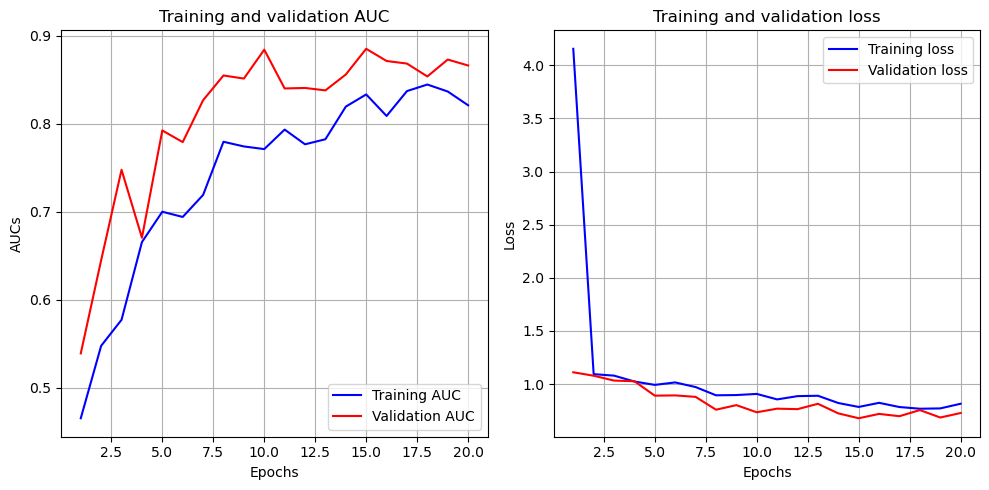

In [47]:
graphique_auc_perte(history, 'model5')

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f17ba5ee980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step


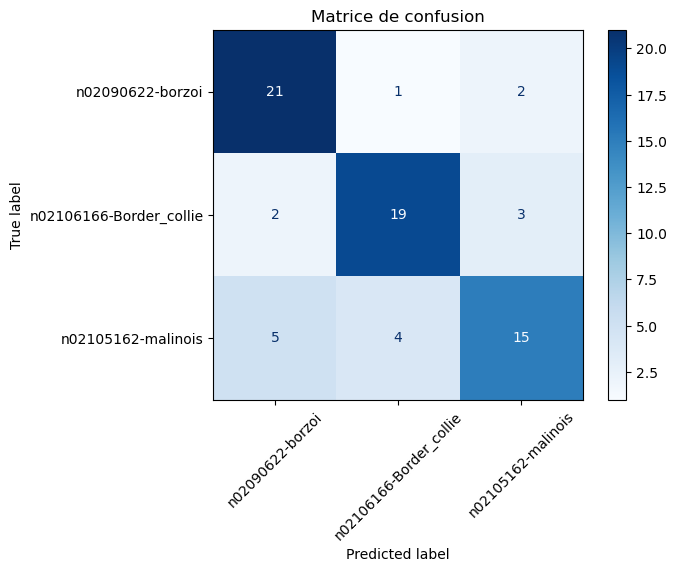

In [49]:
matrice_confusion(model, 'model5', val_generator, class_names)

In [51]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 4, 
          'nbr_couches_convolutionnelles' : 3, 
          'optimizer' : 'Adam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 20}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model5.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model5.png'}

mt.log_mlflow_run('CNN_3_couches_avec_data_augmentation', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-3-couches')

2024/07/17 11:00:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [53]:
# Construction du modèle CNN
model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(256, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(3, activation='softmax')  # 3 classes
                   ])

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
history, temps_execution = compile_and_train(model, train_generator, val_generator)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.3349 - auc: 0.5081 - loss: 2.3579 - precision: 0.2828 - recall: 0.1413 - val_accuracy: 0.3333 - val_auc: 0.5474 - val_loss: 1.0978 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3395 - auc: 0.5045 - loss: 1.1008 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5139 - val_auc: 0.6430 - val_loss: 1.0911 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4638 - auc: 0.6110 - loss: 1.0900 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4167 - val_auc: 0.6591 - val_loss: 1.0720 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4275 - auc: 0.6200 - loss: 1.0700 - precision: 0.1867 - recall: 0.0029 - val_accuracy: 0.4722 - val_auc: 0.6395 

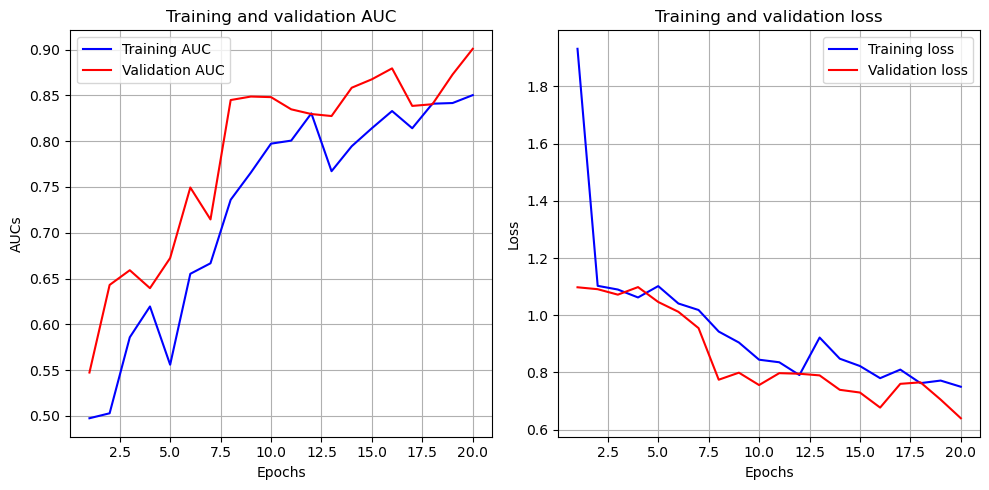

In [57]:
graphique_auc_perte(history, 'model6')

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step


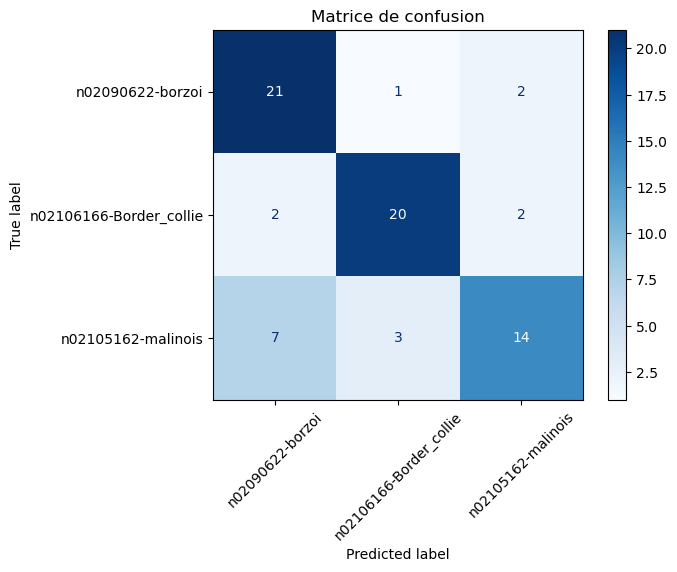

In [59]:
matrice_confusion(model, 'model6', val_generator, class_names)

In [61]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 5, 
          'nbr_couches_convolutionnelles' : 4, 
          'optimizer' : 'Adam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 20}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model6.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model6.png'}

mt.log_mlflow_run('CNN_4_couches_avec_data_augmentation', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-4-couches')

2024/07/17 11:31:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [63]:
# Construction du modèle CNN
model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(256, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(3, activation='softmax')  # 3 classes
                   ])

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
history, temps_execution = compile_and_train(model, train_generator, val_generator, optimizer=Nadam)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.3408 - auc: 0.5263 - loss: 2.2180 - precision: 0.3219 - recall: 0.1207 - val_accuracy: 0.3750 - val_auc: 0.5725 - val_loss: 1.0939 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3175 - auc: 0.5104 - loss: 1.1579 - precision: 0.2250 - recall: 0.0405 - val_accuracy: 0.3472 - val_auc: 0.5635 - val_loss: 1.0927 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3514 - auc: 0.5498 - loss: 1.0961 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5556 - val_auc: 0.7081 - val_loss: 1.0880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4693 - auc: 0.6448 - loss: 1.0802 - precision: 0.1000 - recall: 6.9444e-04 - val_accuracy: 0.4028 - val_auc: 0.6385 - va

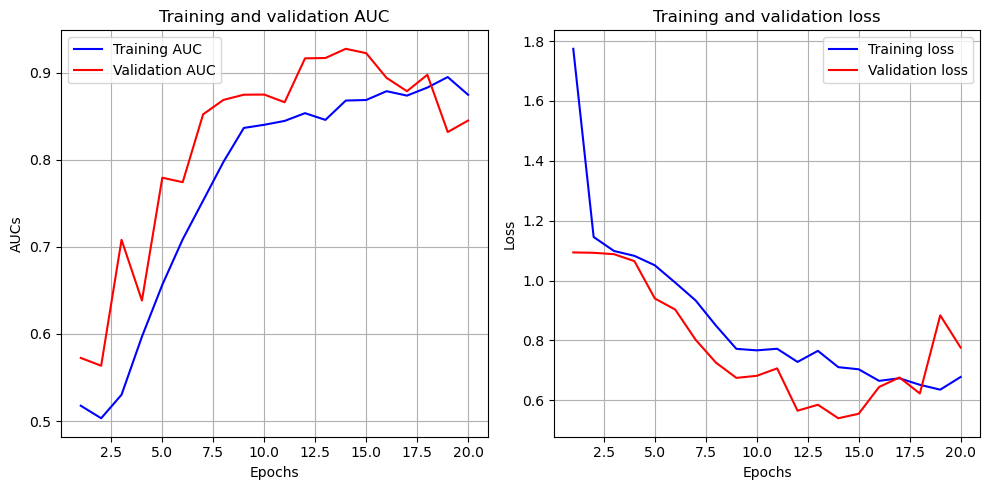

In [67]:
graphique_auc_perte(history, 'model7')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step


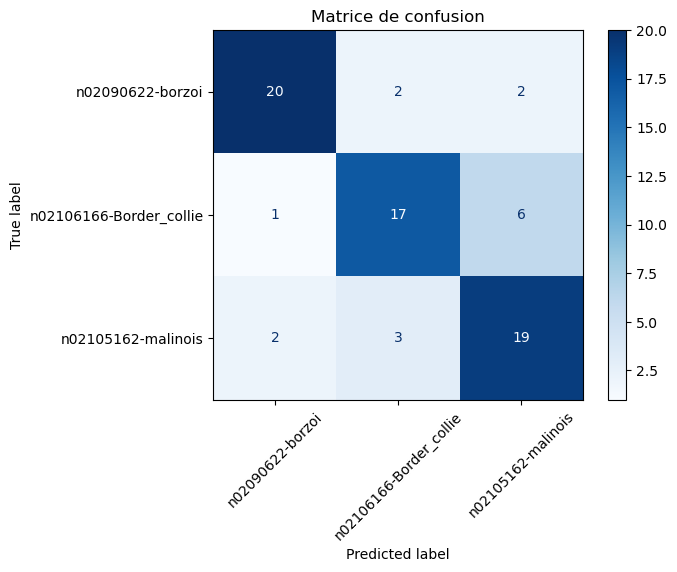

In [69]:
matrice_confusion(model, 'model7', val_generator, class_names)

In [71]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 5, 
          'nbr_couches_convolutionnelles' : 4, 
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 20}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model7.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model7.png'}

mt.log_mlflow_run('CNN_4_couches_avec_data_augmentation_nadam', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-4-couches')

2024/07/17 11:51:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [73]:
history, temps_execution = compile_and_train(model, train_generator, val_generator, optimizer=Nadam, epochs=100)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7157 - auc: 0.8565 - loss: 0.7502 - precision: 0.7547 - recall: 0.6618 - val_accuracy: 0.7778 - val_auc: 0.9029 - val_loss: 0.6067 - val_precision: 0.8030 - val_recall: 0.7361 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6698 - auc: 0.8345 - loss: 0.7803 - precision: 0.7231 - recall: 0.5828 - val_accuracy: 0.7361 - val_auc: 0.8969 - val_loss: 0.6311 - val_precision: 0.8000 - val_recall: 0.7222 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7259 - auc: 0.8728 - loss: 0.6828 - precision: 0.7536 - recall: 0.6242 - val_accuracy: 0.8056 - val_auc: 0.9112 - val_loss: 0.5839 - val_precision: 0.8281 - val_recall: 0.7361 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7066 - auc: 0.8691 - loss: 0.6954 - precision: 0.7811 - recall: 0.6712 - val_accuracy: 0.7361 - val_auc: 0.9039 - val_loss: 0.5931 - val_precision: 

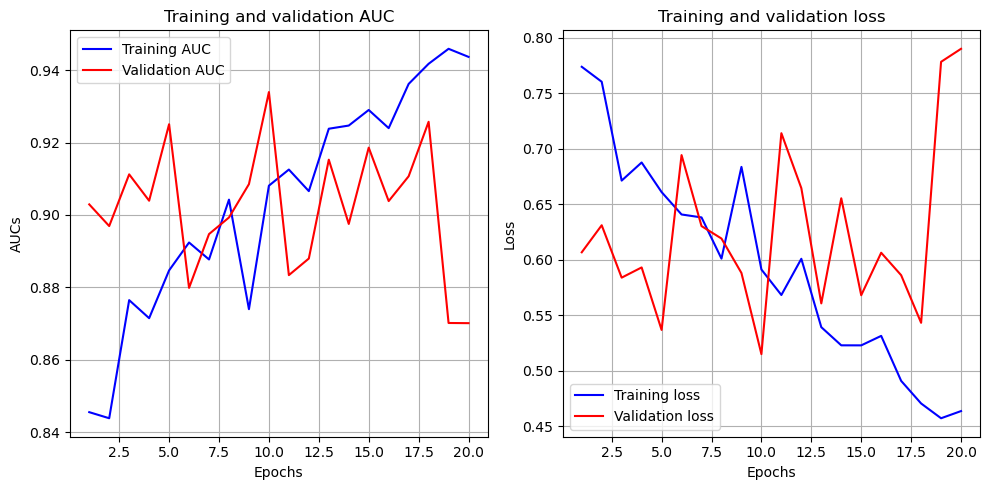

In [75]:
graphique_auc_perte(history, 'model7_suite')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step


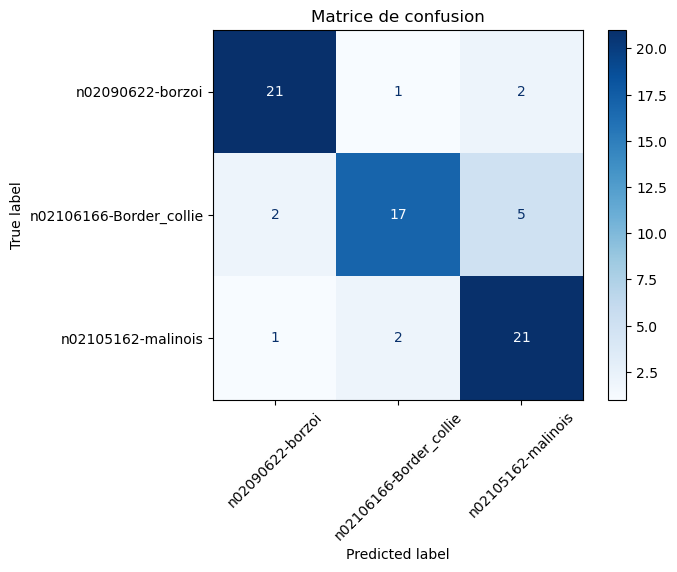

In [77]:
matrice_confusion(model, 'model7_suite', val_generator, class_names)

In [79]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 5, 
          'nbr_couches_convolutionnelles' : 4, 
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 40}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model7_suite.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model7_suite.png'}

mt.log_mlflow_run('CNN_4_couches_avec_data_augmentation_nadam_suite', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-4-couches')

2024/07/17 12:19:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [19]:
# Construction du modèle CNN
def create_model(dropout):
    model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                        MaxPooling2D((2, 2)),
                        Dropout(dropout),
                        Conv2D(64, (3, 3), padding='same', activation='relu'),
                        MaxPooling2D((2, 2)),
                        Dropout(dropout),
                        Conv2D(128, (3, 3), padding='same', activation='relu'),
                        MaxPooling2D((2, 2)),
                        Dropout(dropout),
                        Conv2D(256, (3, 3), padding='same', activation='relu'),
                        MaxPooling2D((2, 2)),
                        Dropout(dropout),
                        Flatten(),
                        Dense(512, activation='relu'),
                        Dropout(dropout),
                        Dense(3, activation='softmax')  # 3 classes
                       ])
    return model

In [21]:
model = create_model(0.2)
history, temps_execution = compile_and_train(model, train_generator, val_generator, optimizer=Nadam, epochs=100)
print(f"durée d'exécution : {temps_execution} min")

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.3298 - auc: 0.5135 - loss: 3.7124 - precision: 0.3229 - recall: 0.1319 - val_accuracy: 0.3194 - val_auc: 0.4693 - val_loss: 1.1005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.3440 - auc: 0.5400 - loss: 1.1088 - precision: 0.3200 - recall: 0.0061 - val_accuracy: 0.3333 - val_auc: 0.5429 - val_loss: 1.0982 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.3460 - auc: 0.5462 - loss: 1.0961 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3333 - val_auc: 0.5326 - val_loss: 1.0970 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.3506 - auc: 0.5334 - loss: 1.0964 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4167 - val_auc: 0.5968 - val_lo

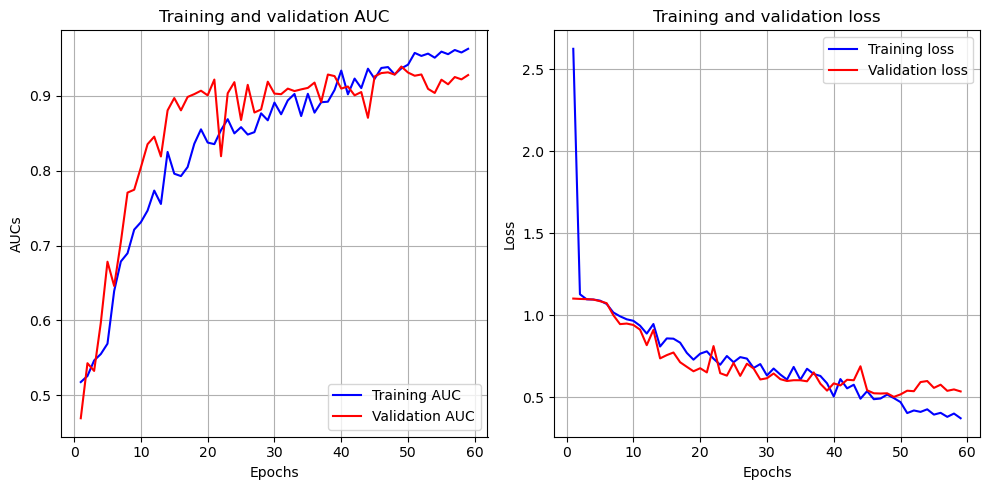

In [23]:
graphique_auc_perte(history, 'model8')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step


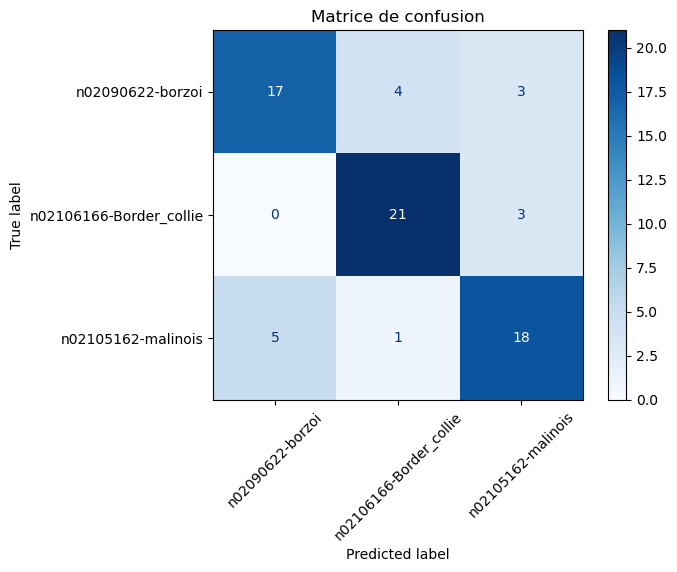

In [25]:
matrice_confusion(model, 'model8', val_generator, class_names)

In [27]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 5, 
          'nbr_couches_convolutionnelles' : 4, 
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 100,
          'dropout' : 0.2}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model8.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model8.png'}

mt.log_mlflow_run('CNN_4_couches_avec_data_augmentation_nadam_dropout_0.2', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-4-couches')

2024/07/17 13:14:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [29]:
model = create_model(0.3)
history, temps_execution = compile_and_train(model, train_generator, val_generator, optimizer=Nadam, epochs=100)
print(f"durée d'exécution : {temps_execution} min")

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.3789 - auc: 0.5391 - loss: 4.0465 - precision: 0.4485 - recall: 0.2457 - val_accuracy: 0.3472 - val_auc: 0.5000 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.3400 - auc: 0.5242 - loss: 1.0979 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3333 - val_auc: 0.5000 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.3961 - auc: 0.5112 - loss: 1.0983 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3333 - val_auc: 0.5000 - val_loss: 1.0987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.3621 - auc: 0.5089 - loss: 1.0989 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3333 - val_

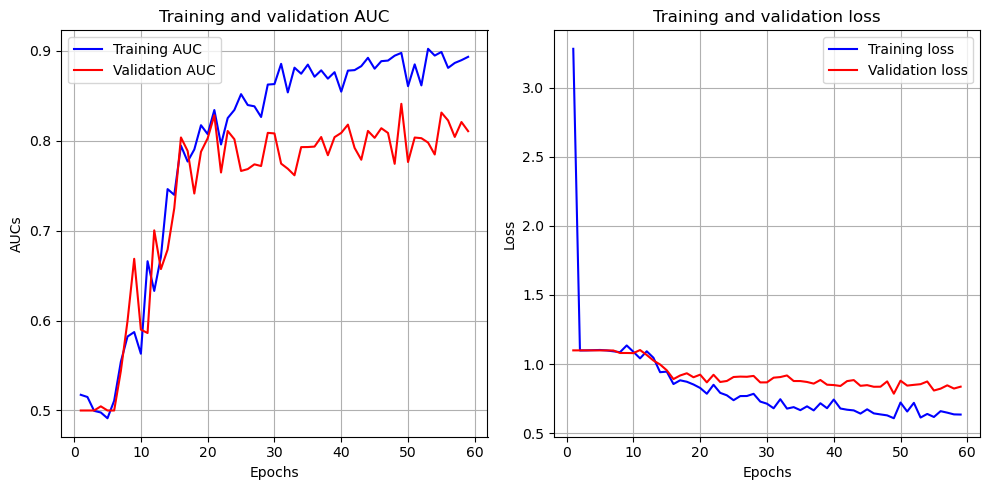

In [31]:
graphique_auc_perte(history, 'model9')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


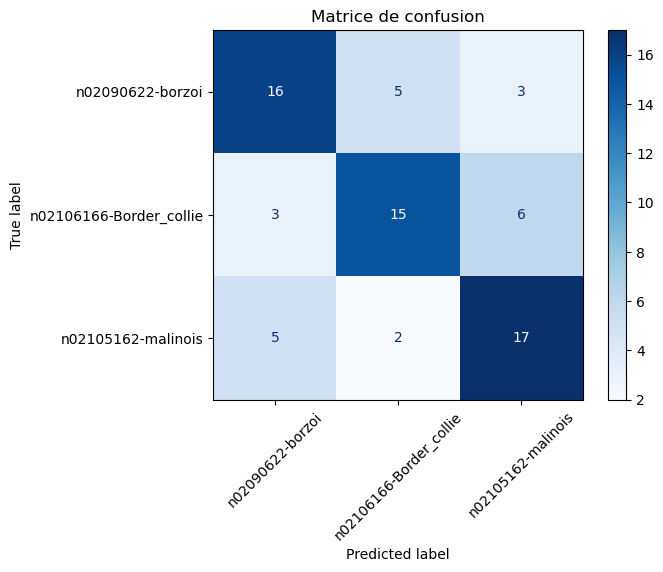

In [33]:
matrice_confusion(model, 'model9', val_generator, class_names)

In [35]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 5, 
          'nbr_couches_convolutionnelles' : 4, 
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 100,
          'dropout' : 0.3}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model9.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model9.png'}

mt.log_mlflow_run('CNN_4_couches_avec_data_augmentation_nadam_dropout_0.3', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-4-couches')

2024/07/17 13:51:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [37]:
model = create_model(0.4)
history, temps_execution = compile_and_train(model, train_generator, val_generator, optimizer=Nadam, epochs=100)
print(f"durée d'exécution : {temps_execution} min")

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.2529 - auc: 0.4467 - loss: 12.2481 - precision: 0.2499 - recall: 0.1882 - val_accuracy: 0.3611 - val_auc: 0.4977 - val_loss: 1.0985 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.3342 - auc: 0.5335 - loss: 1.0968 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3333 - val_auc: 0.4954 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.2917 - auc: 0.4853 - loss: 1.0985 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3333 - val_auc: 0.5000 - val_loss: 1.0987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.3507 - auc: 0.5533 - loss: 1.0977 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3333 - val

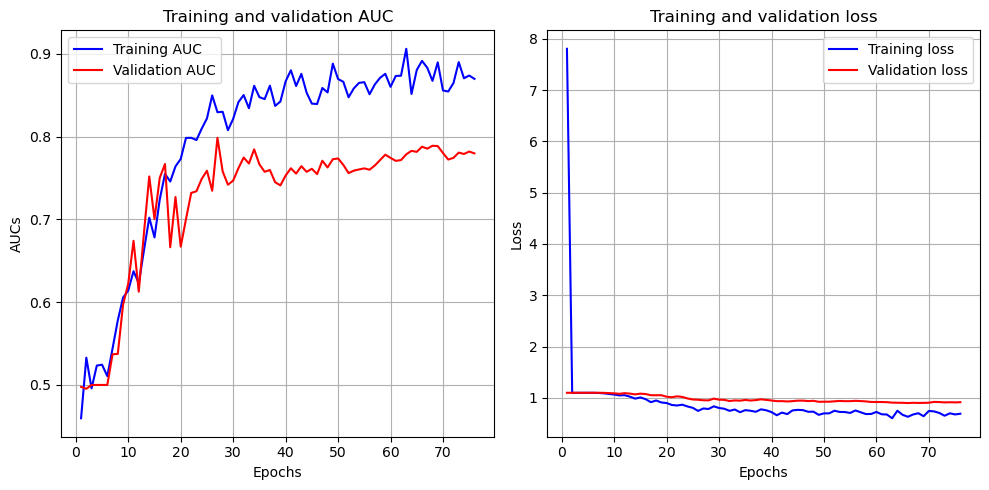

In [39]:
graphique_auc_perte(history, 'model10')

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f3e2b2b0720> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step


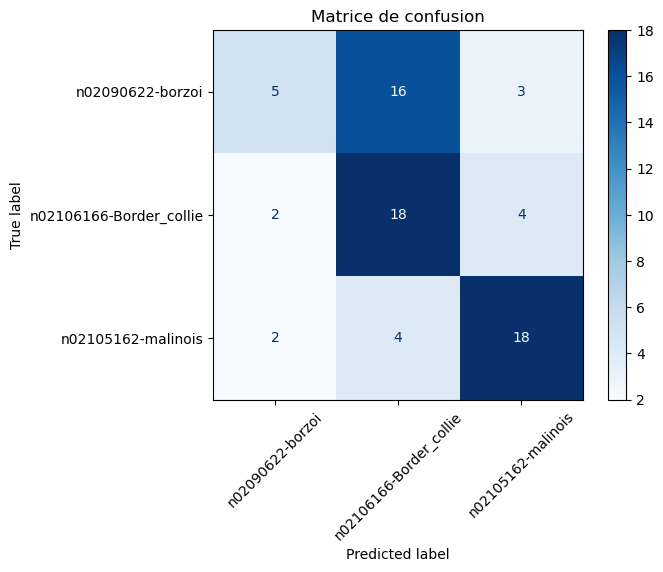

In [41]:
matrice_confusion(model, 'model10', val_generator, class_names)

In [43]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 5, 
          'nbr_couches_convolutionnelles' : 4, 
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 100,
          'dropout' : 0.4}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model10.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model10.png'}

mt.log_mlflow_run('CNN_4_couches_avec_data_augmentation_nadam_dropout_0.4', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-4-couches')

2024/07/17 15:42:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [45]:
# Construction du modèle CNN
model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(256, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(512, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(3, activation='softmax')  # 3 classes
                   ])

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
history, temps_execution = compile_and_train(model, train_generator, val_generator, optimizer=Nadam, epochs=100)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.3833 - auc: 0.5323 - loss: 1.8700 - precision: 0.3308 - recall: 0.1178 - val_accuracy: 0.3333 - val_auc: 0.5046 - val_loss: 1.0984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3372 - auc: 0.4951 - loss: 1.0988 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3750 - val_auc: 0.5046 - val_loss: 1.0981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3475 - auc: 0.4919 - loss: 1.0983 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4167 - val_auc: 0.5208 - val_loss: 1.0973 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4133 - auc: 0.5481 - loss: 1.0983 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5556 - val_

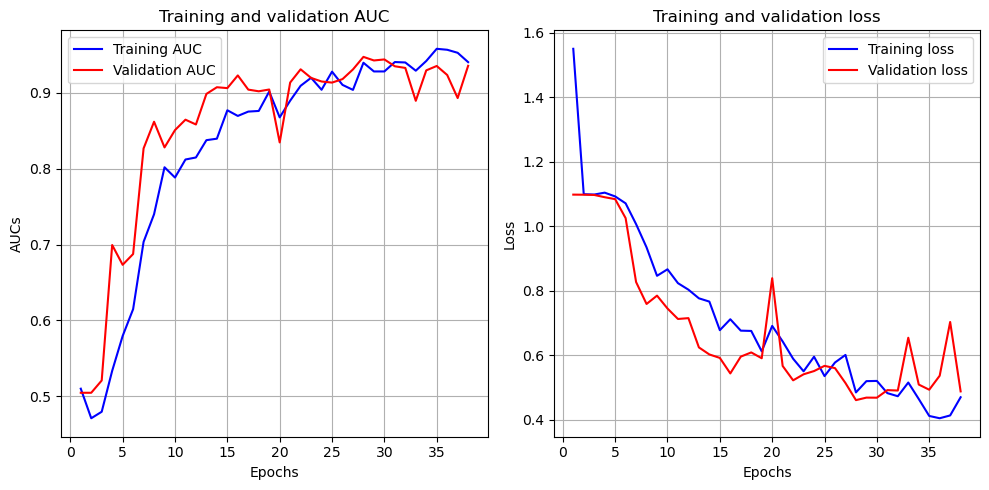

In [49]:
graphique_auc_perte(history, 'model11')

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step


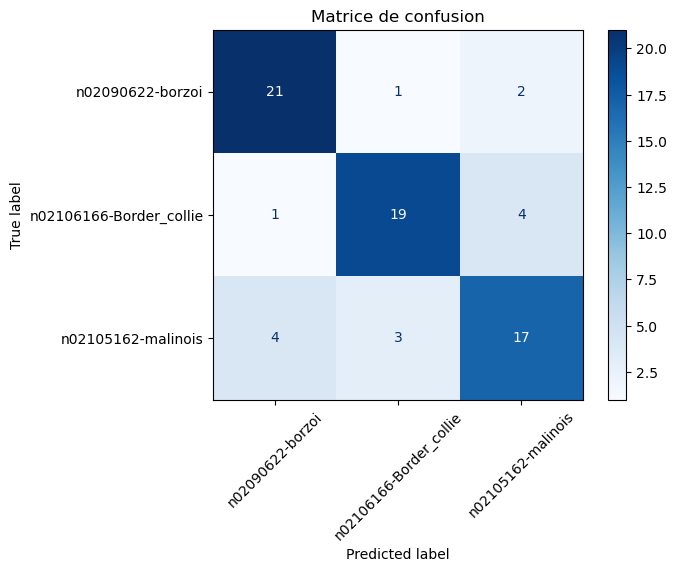

In [51]:
matrice_confusion(model, 'model11', val_generator, class_names)

In [53]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 6, 
          'nbr_couches_convolutionnelles' : 5, 
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 100}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model11.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model11.png'}

mt.log_mlflow_run('CNN_5_couches_avec_data_augmentation_nadam', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-5-couches')

2024/07/17 16:33:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [22]:
# Construction du modèle CNN
model = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
                    MaxPooling2D((2, 2)),
                    Dropout(0.2),
                    Conv2D(64, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Dropout(0.2),
                    Conv2D(128, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Dropout(0.2),
                    Conv2D(256, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Dropout(0.2),
                    Conv2D(512, (3, 3), padding='same', activation='relu'),
                    MaxPooling2D((2, 2)),
                    Dropout(0.2),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dropout(0.2),
                    Dense(3, activation='softmax')  # 3 classes
                   ])

/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
history, temps_execution = compile_and_train(model, train_generator, val_generator, optimizer=Nadam, epochs=100)
print(f"durée d'exécution : {temps_execution} min")

Epoch 1/100


/home/chakir/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.3551 - auc: 0.5271 - loss: 2.6737 - precision: 0.3098 - recall: 0.0908 - val_accuracy: 0.4028 - val_auc: 0.4931 - val_loss: 1.0985 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4189 - auc: 0.5264 - loss: 1.0973 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3472 - val_auc: 0.5115 - val_loss: 1.0988 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.3496 - auc: 0.5184 - loss: 1.0974 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4167 - val_auc: 0.4826 - val_loss: 1.0984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4527 - auc: 0.5900 - loss: 1.0961 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4028 - val_auc: 0.5897 

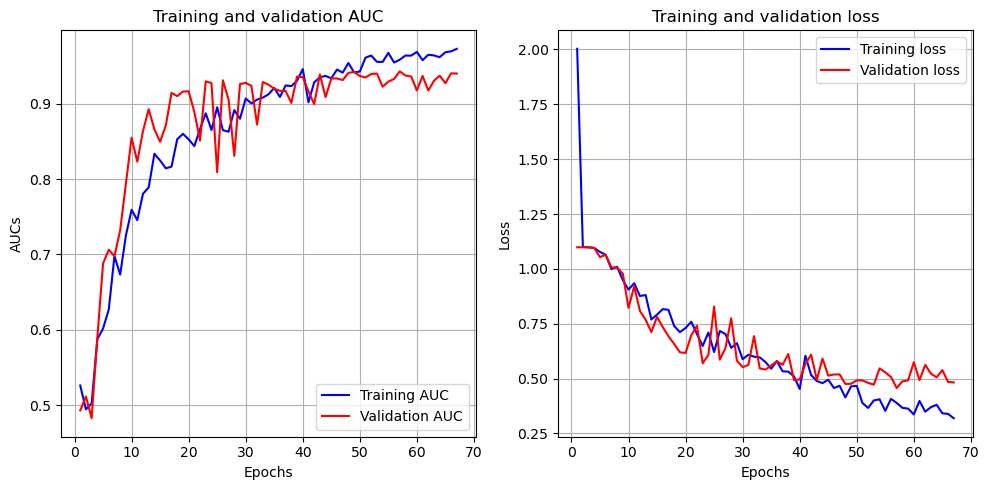

In [26]:
graphique_auc_perte(history, 'model12')

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step


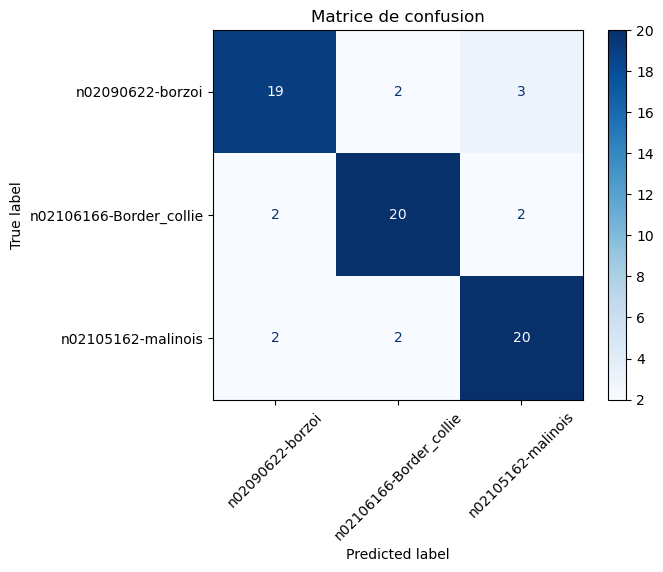

In [28]:
matrice_confusion(model, 'model12', val_generator, class_names)

In [30]:
params = {'algorithme' : 'CNN_personnel', 
          'nbr_couches' : 6, 
          'nbr_couches_convolutionnelles' : 5, 
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 100,
          'dropout' : 0.2}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'CNN'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_model12.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_model12.png'}

mt.log_mlflow_run('CNN_5_couches_avec_data_augmentation_nadam_dropout_0.2', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='CNN-5-couches')

2024/07/17 18:55:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
